# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.  

Visualizations found in this notebook:
- Number of confirmed cases/deaths/recovered in each country/state
- How far behind a country/state is from another country/state by comparing the fraction of the population infected
- Countries/states with the most confirmed cases/deaths/new confirmed cases/new deaths

# Imports and definitions

In [256]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = 12,6
plt.style.use('seaborn-dark-palette')
#plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

# Load data

In [320]:
# define paths to each raw file
d_ts = {}
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [334]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [335]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')

metric: confirmed at 2020-03-18 00:32:47.348245
metric: deaths at 2020-03-18 00:32:48.364685
metric: recovered at 2020-03-18 00:32:49.455007


In [295]:
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

Latest data from 2020-03-17


In [350]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   'recovered': np.sum,
               }))
dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']

##### Top 10 countries by confirmed COVID-19 cases

In [352]:
# get the top countries
agg_funcs = {'confirmed': np.max, 
             'confirmed_new': np.max, 
             'deaths': np.max, 
             'deaths_new': np.max,
             'active': np.max,
            }
dfp_top_countries = (dfp_country[dfp_country['date'] == dfp_country['date'].max()].
                     groupby(['date', 'country'], as_index=False).
                     agg(agg_funcs)
                    )
dfp_top_countries = dfp_top_countries.sort_values(by='active', ascending=0).reset_index(drop=True)
for key, _ in agg_funcs.items():
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(10)

,date,country,confirmed,confirmed_new,deaths,deaths_new,active
0,2020-03-17,Italy,31506,3526,2503,345,28565
1,2020-03-17,China,81058,25,3230,13,12260
2,2020-03-17,Iran,16169,1178,988,135,10780
3,2020-03-17,Spain,11748,1806,533,191,10720
4,2020-03-17,Germany,9257,1985,24,7,9190
5,2020-03-17,France,7683,1024,148,0,7671
6,2020-03-17,"Korea, South",8320,84,81,6,6913
7,2020-03-17,US,6421,1789,108,23,6404
8,2020-03-17,Switzerland,2700,500,27,13,2696
9,2020-03-17,United Kingdom,1960,409,56,0,1907


# Plot the infections for the top countries

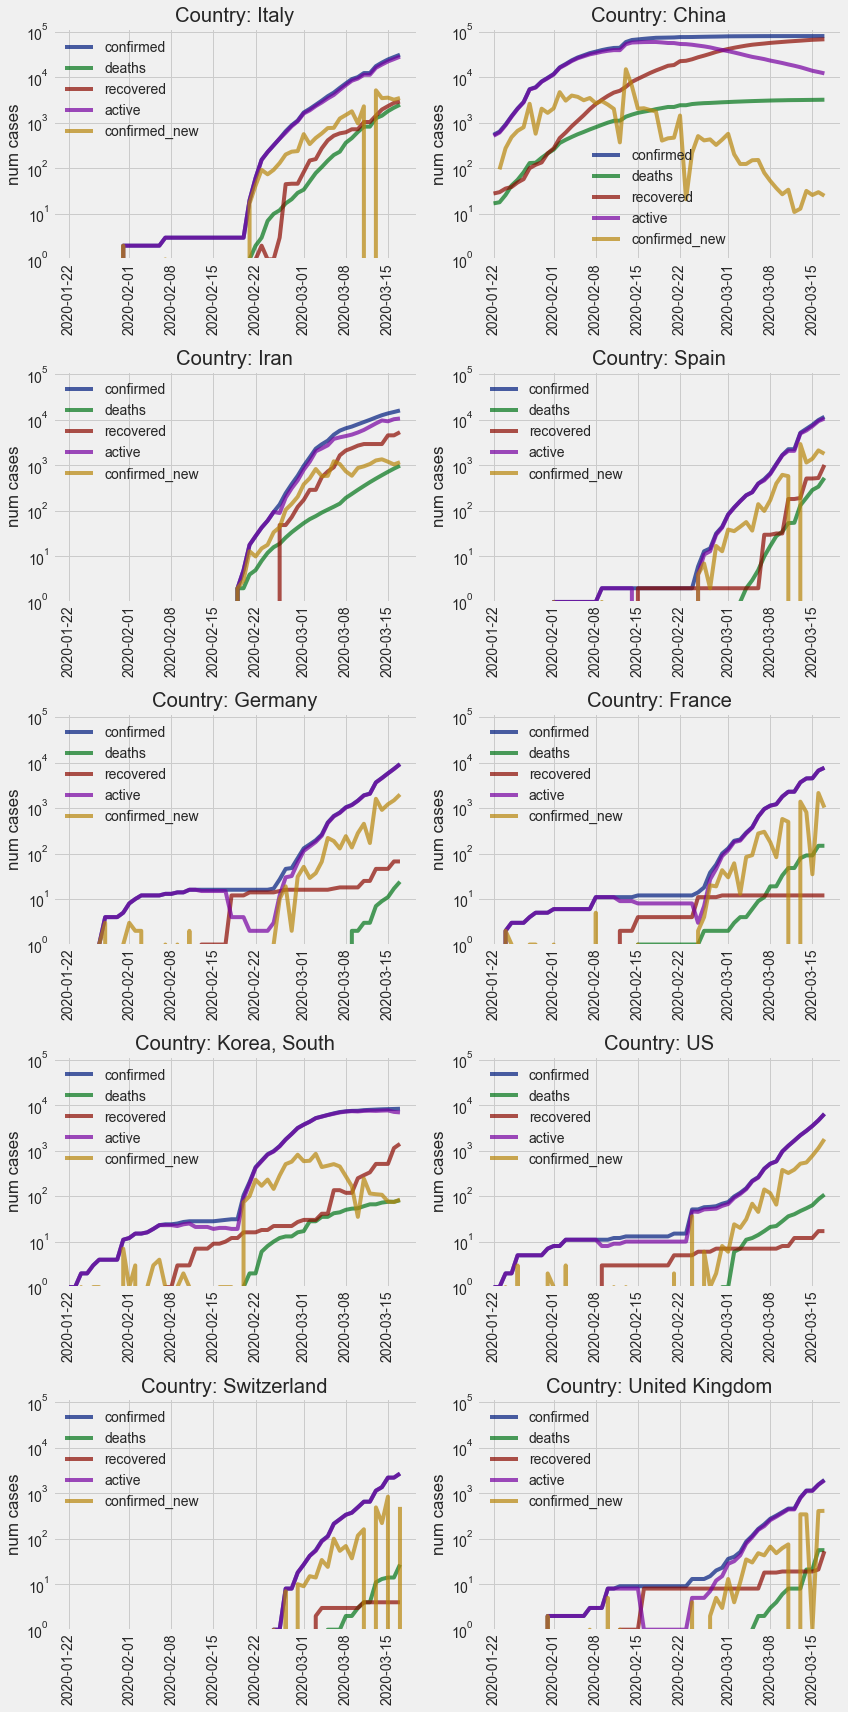

In [341]:
# plot the top countries
i = 1
n_countries = 10
n_columns = 2
n_rows = int(np.ceil(n_countries / n_columns))
plt.figure(figsize=(12,24))
y_max = dfp_top_countries['confirmed'].max() * 1.5

for country in dfp_top_countries.iloc[:n_countries]['country']:
    dfp_plot = dfp_country[dfp_country['country'] == country]
    plt.subplot(n_rows, n_columns, i)
    for key in list(d_data.keys()) + ['active', 'confirmed_new']:
        plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.7, label=key)
    plt.legend(loc='best')
    plt.ylabel('num cases')
    plt.title(f'Country: {country}')
    plt.yscale('log')
    plt.ylim([1, y_max])
    plt.xticks(rotation=90)
    
    i += 1
plt.tight_layout()
plt.show()

# Normalize infections by population

Population data taken from https://www.worldometers.info/world-population/population-by-country/ on 2020-03-16

In [121]:
dfp_world_pop = pd.read_csv('supporting_data/country_population_data.csv')

In [122]:
# clean population data
dfp_world_pop = dfp_world_pop.rename(columns={
    'Country (or dependency)': 'country', 
    'Population\n (2020)': 'population'
})
dfp_world_pop['population'] = dfp_world_pop['population'].apply(lambda x: float(x.replace(',', '')))

In [123]:
translations = {'South Korea': 'Korea, South',
                'United States': 'US',
               }
for old, new in translations.items():
    try:
        dfp_world_pop['country'][np.where(dfp_world_pop['country'] == old)[0][0]] = new
    except Exception as e:
        pass  #print(e)

/Users/tboats/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [124]:
# filter in only the top countries
top_n = 10
pop_cols = ['country', 'population']
dfp_country_top = dfp_country.merge(dfp_top_countries.iloc[:top_n]['country'], on='country', how='inner')
dfp_country_top_dec = dfp_country_top.merge(dfp_world_pop[pop_cols], on='country', how='left')
dfp_country_top_dec['confirmed_frac'] = dfp_country_top_dec['confirmed'] / dfp_country_top_dec['population']
dfp_country_top_dec['deaths_frac'] = dfp_country_top_dec['deaths'] / dfp_country_top_dec['population']

# How many days behind is each country?

In [362]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_top_dec, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

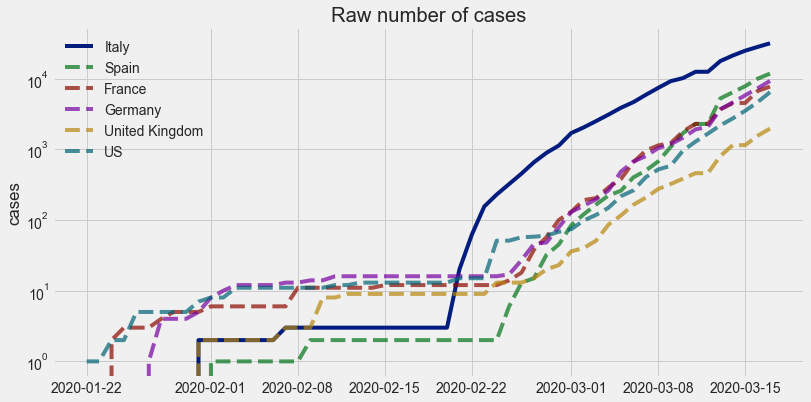

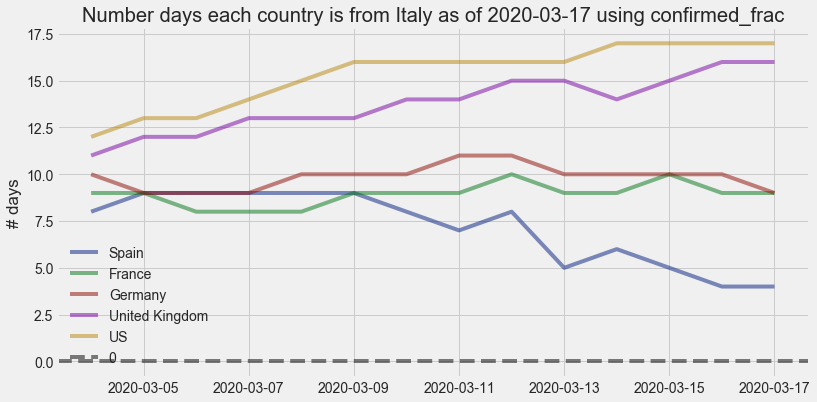

In [363]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', compare_col='confirmed_frac')

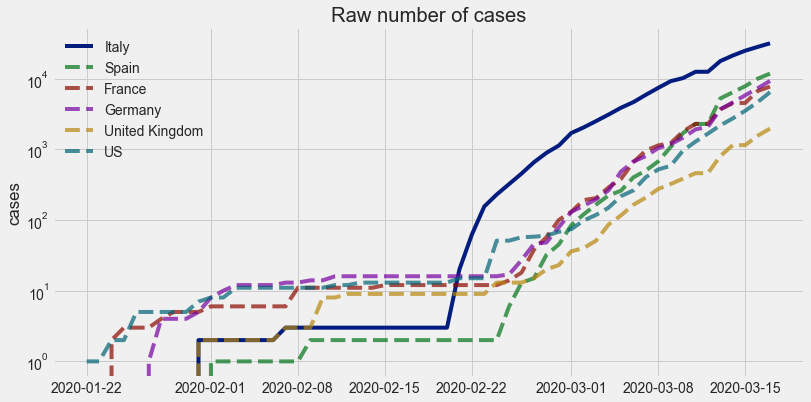

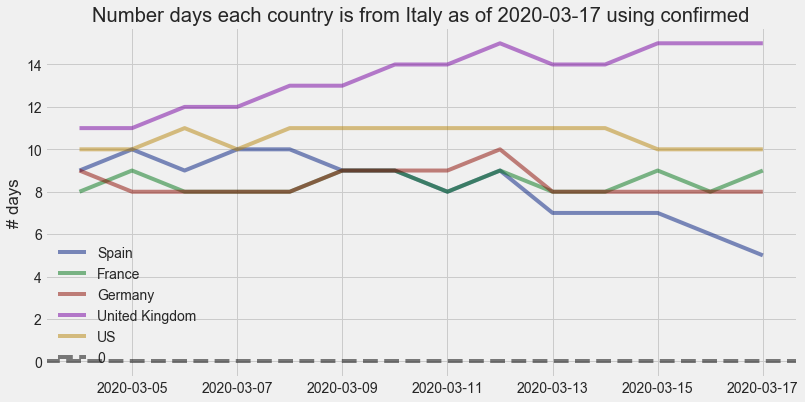

In [364]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', compare_col='confirmed')

# US state breakdown

In [132]:
# look only at the US
dfp_us_raw = dfp[dfp['country'] == 'US']
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

/Users/tboats/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [353]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state_clean'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state_clean'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']

### States with the most new infections

In [355]:
agg_funcs = {'confirmed': np.max, 
             'confirmed_new': np.max, 
             'deaths': np.max, 
             'deaths_new': np.max,
             'active': np.max,
            }
dfp_us_top_states = (dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()].
                     groupby(['date', 'state_clean'], as_index=False).
                     agg(agg_funcs).
                     sort_values(by='confirmed_new', ascending=0).
                     reset_index(drop=True)
                    )
for col, _ in agg_funcs.items():
    dfp_us_top_states[col] = dfp_us_top_states[col].apply(int)
dfp_us_top_states.head(10)

,date,state_clean,confirmed,confirmed_new,deaths,deaths_new,active
0,2020-03-17,New York,1706,739,13,3,1706
1,2020-03-17,Washington,1076,172,55,7,1075
2,2020-03-17,California,698,141,12,5,692
3,2020-03-17,New Jersey,267,89,3,1,266
4,2020-03-17,Florida,216,61,6,1,216
5,2020-03-17,Louisiana,196,60,4,1,196
6,2020-03-17,Illinois,161,56,1,1,159
7,2020-03-17,Connecticut,68,38,0,0,68
8,2020-03-17,Pennsylvania,112,35,0,0,112
9,2020-03-17,Oregon,66,27,1,0,66


### Plot of infections in top states

In [344]:
#states_oi = ['Washington', 'New York', 'California']
states_oi = dfp_us_top_states.iloc[:6]['state_clean'].values
plot_col = 'confirmed'

def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):

    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state_clean'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

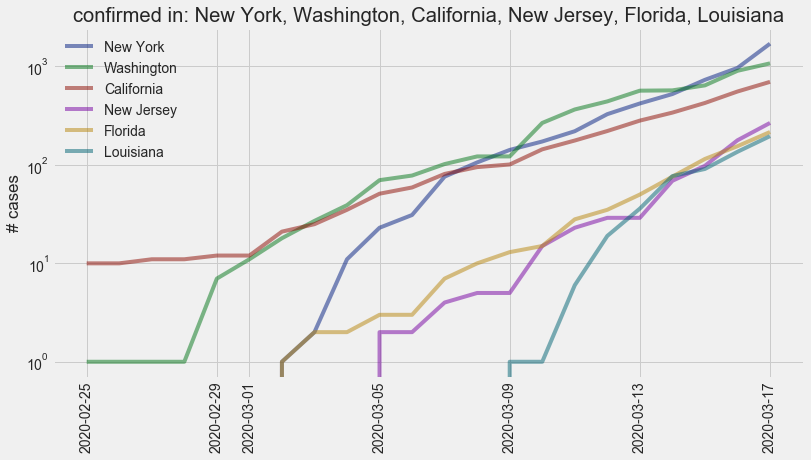

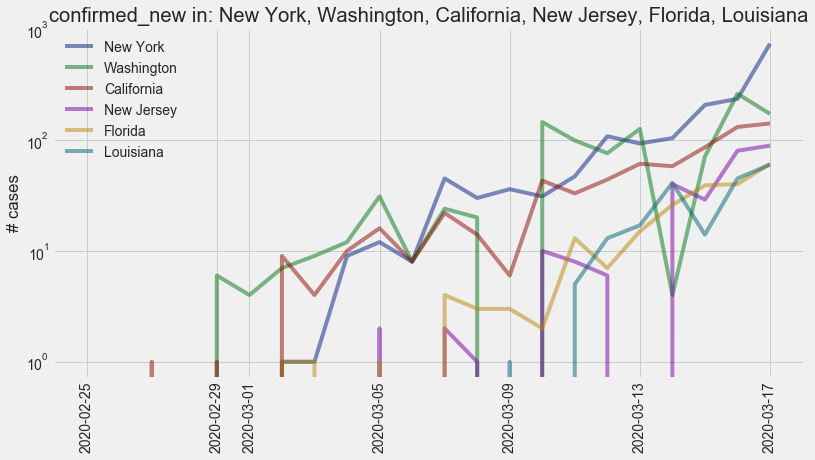

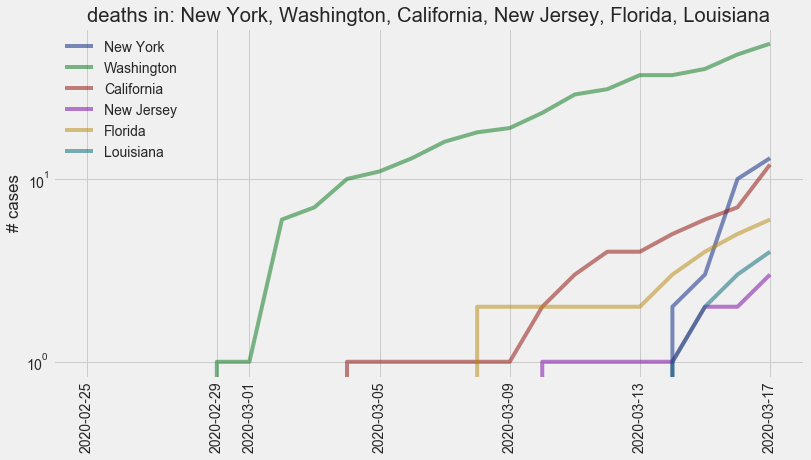

In [365]:
states_oi = dfp_us_top_states.iloc[:6]['state_clean'].values
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed')
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new')
plot_state_data(dfp_us_g, states_oi, plot_col='deaths')

##### Compare against Washington

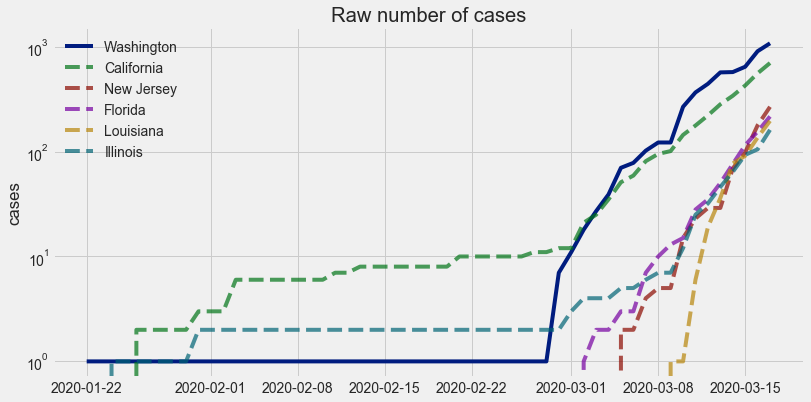

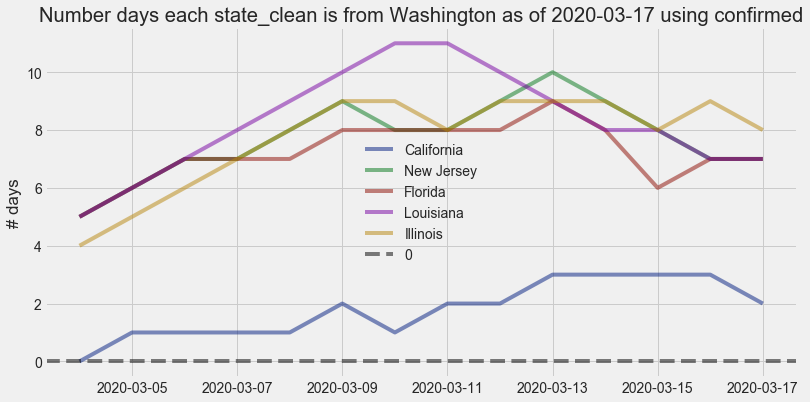

In [366]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state_clean', 
                              compare_col='confirmed'
                             )

##### Compare against New York

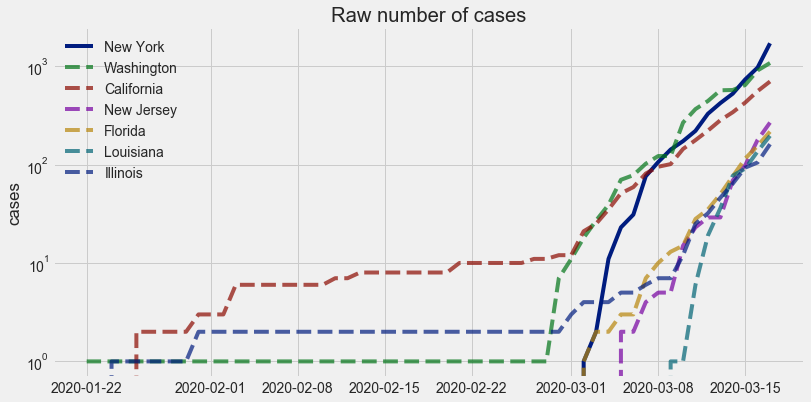

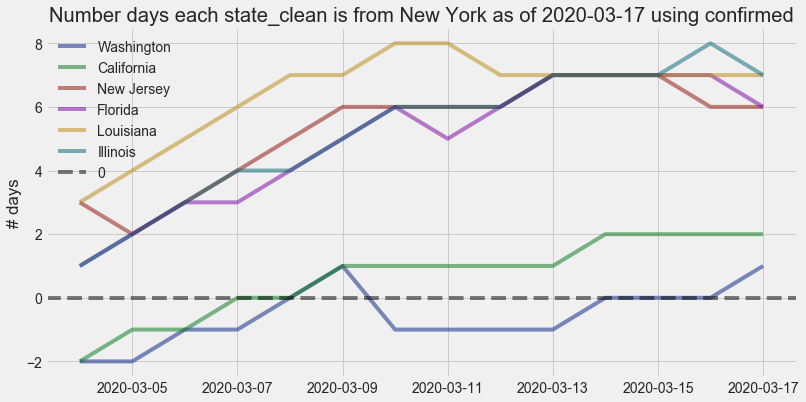

In [367]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state_clean', 
                              compare_col='confirmed'
                             )